

##### Refernce  BOW IN WONDER LAND  https://www.kaggle.com/code/bowinlavenderfield/happy-whale-dolphin-type-classification/notebook   4 votes
##### Refernce  SIRISAP                https://www.kaggle.com/code/sirisap/whales-dolphins-vision-transformer                            1 votes



In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import cv2

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


import torchvision
from torchvision import transforms
import torchvision.models as models


## Utils
import joblib
from tqdm import tqdm
import gc

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

CONFIG = {
    'EPOCHS': 70,
    'img_size': 224,
    'seed': 22,
    'train_batch_size': 64,
    'test_batch_size': 64,
    'num_classes': 2,
    'device' : "mps" if getattr(torch,'has_mps',False) else "gpu" if torch.cuda.is_available() else "cpu"
}

CONFIG

{'EPOCHS': 70,
 'img_size': 224,
 'seed': 22,
 'train_batch_size': 64,
 'test_batch_size': 64,
 'num_classes': 2,
 'device': 'mps'}

# Index

In [3]:
Train_Base_path = "./alien_vs_predator_data/train/"

timage=[]
tlabels=[]
for folder in os.listdir(Train_Base_path):
    if os.path.isdir(Train_Base_path+folder):
        for file in os.listdir(Train_Base_path+folder):
            timage.append(Train_Base_path+folder+"/"+file)
            tlabels.append(folder)
    
print("number of train images",len(timage))

number of train images 694


In [4]:

Validate_Base_path = "./alien_vs_predator_data/validation/"

vimage=[]
vlabels=[]
for folder in os.listdir(Validate_Base_path):
    if os.path.isdir(Validate_Base_path+folder):
        for file in os.listdir(Validate_Base_path+folder):
            vimage.append(Validate_Base_path+folder+"/"+file)
            vlabels.append(folder)

print("number of validate images",len(vimage))

number of validate images 200


# Lablled data Training

In [5]:
df_train_data = {'Images':timage, 'labels':tlabels} 
df_train_data = pd.DataFrame(df_train_data) 
df_train_data.sample(10)


,Images,labels
631,./alien_vs_predator_data/train/alien/155.jpg,alien
453,./alien_vs_predator_data/train/alien/117.jpg,alien
540,./alien_vs_predator_data/train/alien/27.jpg,alien
425,./alien_vs_predator_data/train/alien/277.jpg,alien
451,./alien_vs_predator_data/train/alien/329.jpg,alien
665,./alien_vs_predator_data/train/alien/79.jpg,alien
613,./alien_vs_predator_data/train/alien/55.jpg,alien
524,./alien_vs_predator_data/train/alien/269.jpg,alien
506,./alien_vs_predator_data/train/alien/280.jpg,alien
386,./alien_vs_predator_data/train/alien/158.jpg,alien


In [6]:
df_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694 entries, 0 to 693
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Images  694 non-null    object
 1   labels  694 non-null    object
dtypes: object(2)
memory usage: 11.0+ KB


In [7]:
df_train_data = {'Images':timage, 'labels':tlabels} 
df_train_data = pd.DataFrame(df_train_data) 

lb = LabelEncoder()
df_train_data['encoded_labels'] = lb.fit_transform(df_train_data['labels'])
df_train_data.sample(10)

,Images,labels,encoded_labels
435,./alien_vs_predator_data/train/alien/29.jpg,alien,0
161,./alien_vs_predator_data/train/predator/337.jpg,predator,1
688,./alien_vs_predator_data/train/alien/147.jpg,alien,0
406,./alien_vs_predator_data/train/alien/239.jpg,alien,0
505,./alien_vs_predator_data/train/alien/257.jpg,alien,0
442,./alien_vs_predator_data/train/alien/300.jpg,alien,0
438,./alien_vs_predator_data/train/alien/116.jpg,alien,0
446,./alien_vs_predator_data/train/alien/275.jpg,alien,0
424,./alien_vs_predator_data/train/alien/288.jpg,alien,0
63,./alien_vs_predator_data/train/predator/172.jpg,predator,1


# Lablled data Validation

In [8]:
df_val_data = {'Images':vimage, 'labels':vlabels} 
df_val_data = pd.DataFrame(df_val_data) 

lb = LabelEncoder()
df_val_data['encoded_labels'] = lb.fit_transform(df_val_data['labels'])

df_val_data.sample(10)


,Images,labels,encoded_labels
22,./alien_vs_predator_data/validation/predator/9...,predator,1
46,./alien_vs_predator_data/validation/predator/3...,predator,1
5,./alien_vs_predator_data/validation/predator/6...,predator,1
32,./alien_vs_predator_data/validation/predator/1...,predator,1
134,./alien_vs_predator_data/validation/alien/39.jpg,alien,0
129,./alien_vs_predator_data/validation/alien/15.jpg,alien,0
57,./alien_vs_predator_data/validation/predator/4...,predator,1
42,./alien_vs_predator_data/validation/predator/3...,predator,1
158,./alien_vs_predator_data/validation/alien/56.jpg,alien,0
51,./alien_vs_predator_data/validation/predator/2...,predator,1


# Dataset and Dataloader

In [9]:
class Dataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['Images'].values
        self.labels = df['encoded_labels'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
       
        label = self.labels[index]
        
        
        if self.transforms:
            img = self.transforms(img)
          
            
        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.long)
        }



data_transforms = {
    'train':
    transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((CONFIG['img_size'],CONFIG['img_size'])),
        transforms.ToTensor(),
       
       
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((CONFIG['img_size'],CONFIG['img_size'])),
        transforms.ToTensor(),
       
     
    ]),
}

In [10]:
train_dataset = Dataset(df_train_data, transforms=data_transforms['train'])
train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], num_workers=0, shuffle=True, drop_last=True)

val_dataset = Dataset(df_val_data, transforms=data_transforms['validation'])
val_loader = DataLoader(val_dataset, batch_size= CONFIG["test_batch_size"], num_workers=2, shuffle=False, drop_last= False)


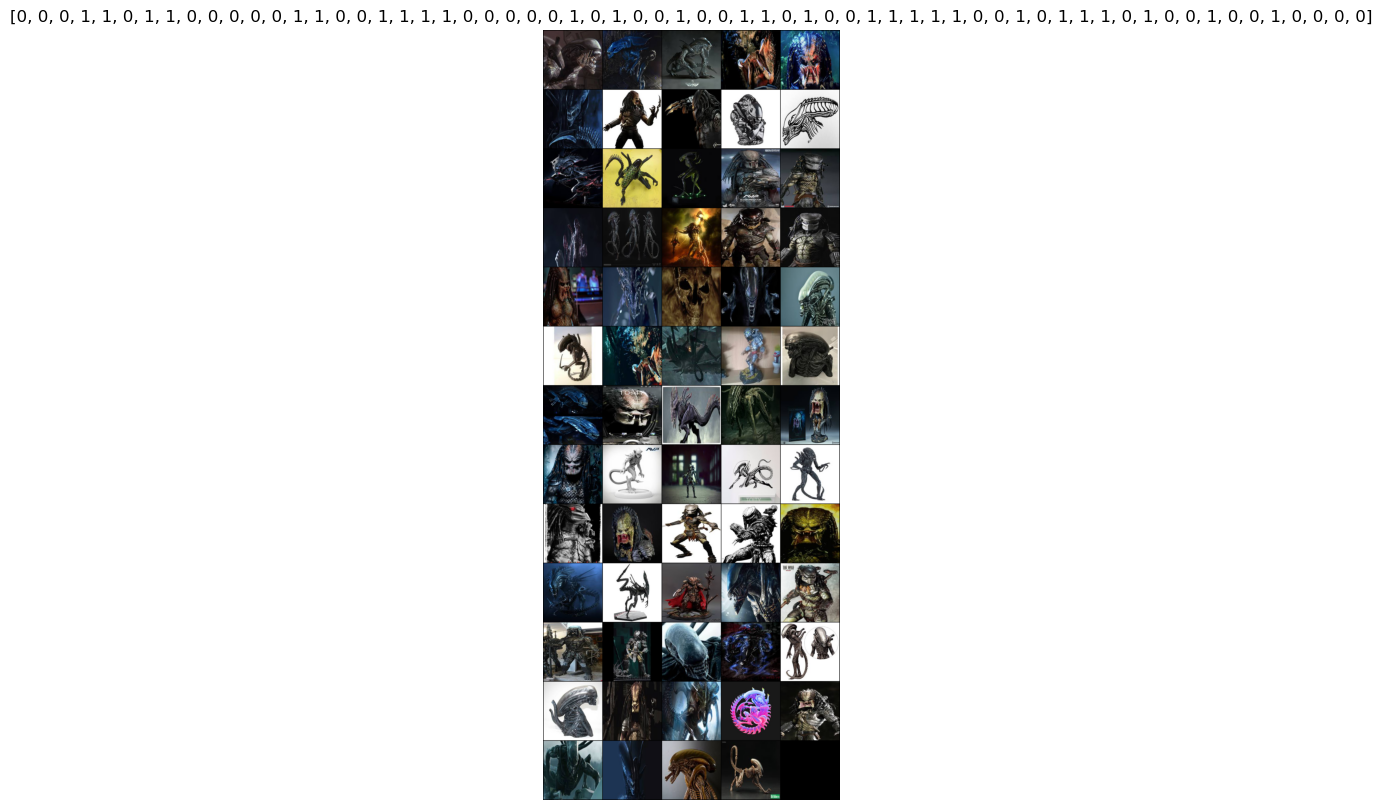

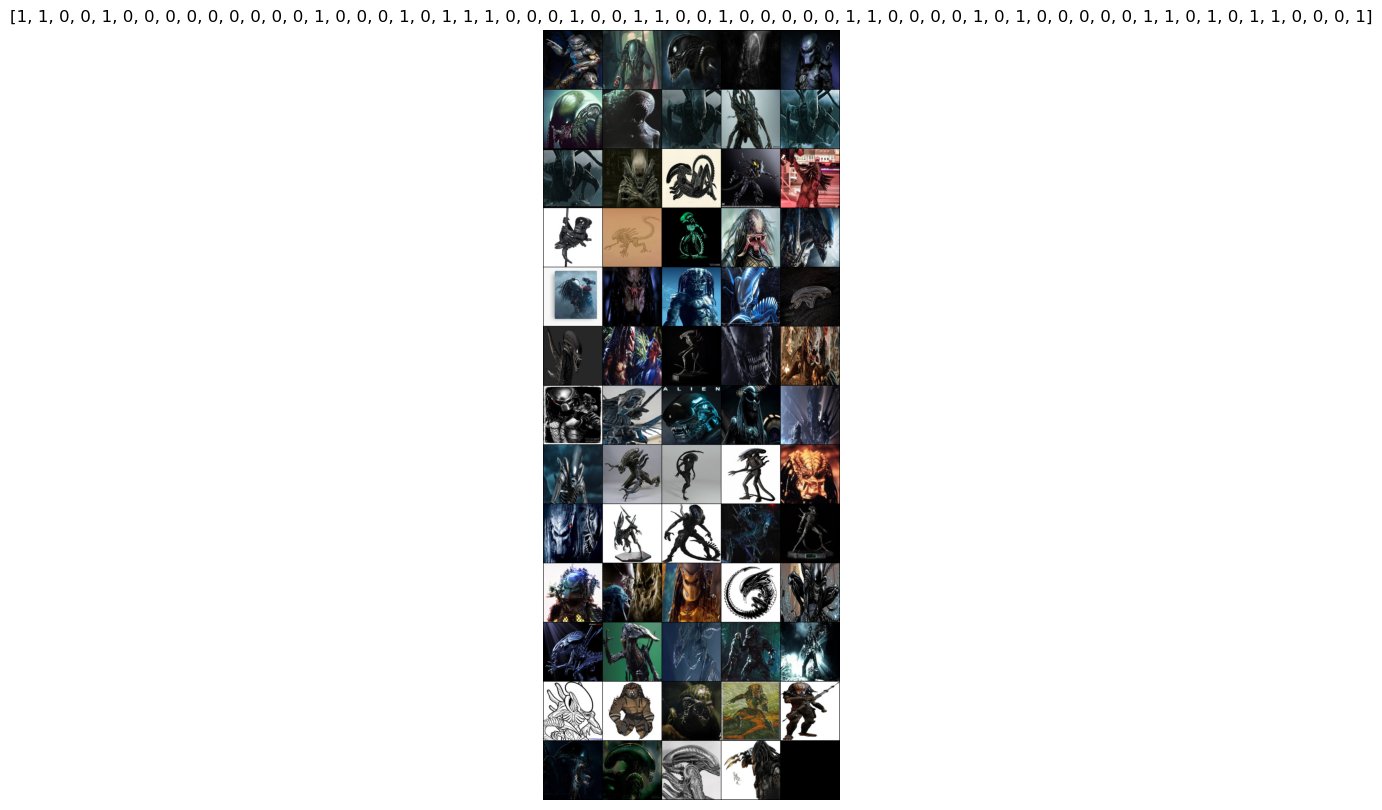

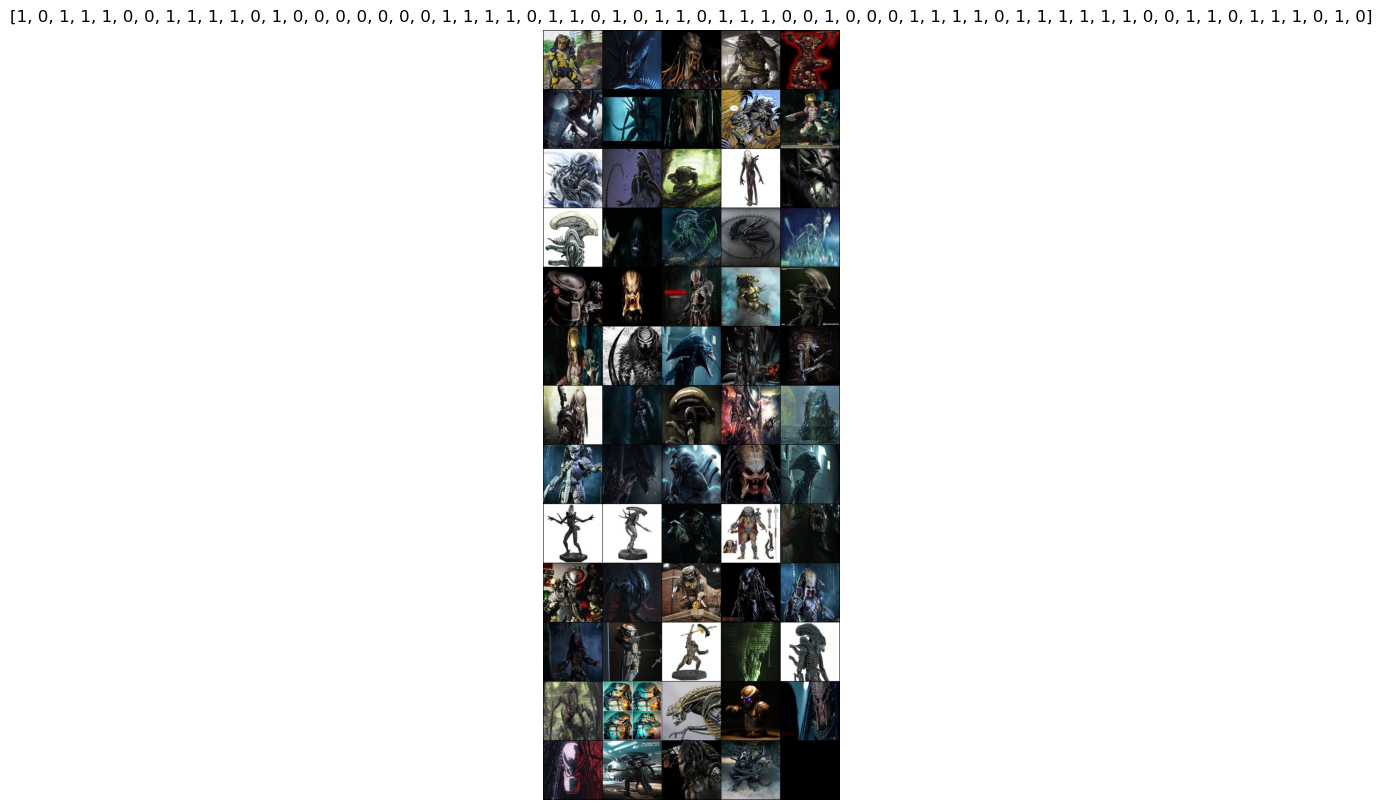

In [11]:
count = 1
for X in train_loader :
    grid = torchvision.utils.make_grid(X['image'], nrow=8)
    plt.figure(figsize=(10,10))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(X['label'].numpy().tolist());
    
    if count >= 3 :
       break
    count += 1

# Transfer learning

In [12]:
net = models.resnet50(pretrained=False)
net

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
device = CONFIG['device']

In [14]:
net = models.resnet50(pretrained=True)
    
for param in net.parameters():
    param.requires_grad = False   
    
net.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

net.to(device)


/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.97)

#lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [16]:
def save_model(path):
    torch.save({
                'epoch': 15,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                'train_loss': training_loss,
                }, path)

In [17]:



training_loss = []
training_Acc = []
train_batch   = CONFIG['train_batch_size']


for epoch in range( CONFIG['EPOCHS']):  
     
      gc.collect()
      net.train()
      train_epoch_loss = 0
      train_epoch_acc = 0

      bar = tqdm(enumerate(train_loader), total=len(train_loader))
      for step, batch in bar:
          images, labels = batch['image'], batch['label']
          images = images.to(device)
          labels= labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

        # forward + backward + optimize
          outputs = net(images)
          _,preds    = torch.max ( torch.softmax(outputs, dim = 1), 1)
         

          running_corrects = torch.sum(preds == labels)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          train_epoch_loss += loss.item()
          train_epoch_acc += running_corrects.item()/train_batch
          
          bar.set_description(f'loss: {loss.item()} acc: {running_corrects.item()/train_batch} batch_id: {step}')
          bar.set_postfix(Epoch=epoch, Train_Loss=train_epoch_loss/len(train_loader),Train_ACC=train_epoch_acc/len(train_loader),LR=optimizer.param_groups[0]['lr']) 

      
      #save_model(path)
      training_loss.append(train_epoch_loss/len(train_loader))
      training_Acc.append(train_epoch_acc/len(train_loader))
      gc.collect()


          

print('Finished Training')

loss: 0.6992620825767517 acc: 0.5 batch_id: 9: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s, Epoch=0, LR=1e-5, Train_ACC=0.43, Train_Loss=0.706]       
loss: 0.6869112253189087 acc: 0.515625 batch_id: 9: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s, Epoch=1, LR=1e-5, Train_ACC=0.544, Train_Loss=0.69] 
loss: 0.681755542755127 acc: 0.546875 batch_id: 9: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s, Epoch=2, LR=1e-5, Train_ACC=0.619, Train_Loss=0.678]  
loss: 0.6530175805091858 acc: 0.75 batch_id: 9: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s, Epoch=3, LR=1e-5, Train_ACC=0.697, Train_Loss=0.663]     
loss: 0.6470706462860107 acc: 0.765625 batch_id: 9: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s, Epoch=4, LR=1e-5, Train_ACC=0.745, Train_Loss=0.651] 
loss: 0.6296840906143188 acc: 0.796875 batch_id: 9: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s, Epoch=5, LR=1e-5, Train_ACC=0.803, Train_Loss=0.637] 
loss: 0.6064777374267578 acc: 0.875 batch_id: 9: 100%|██████████| 10/10 [00:0

Finished Training


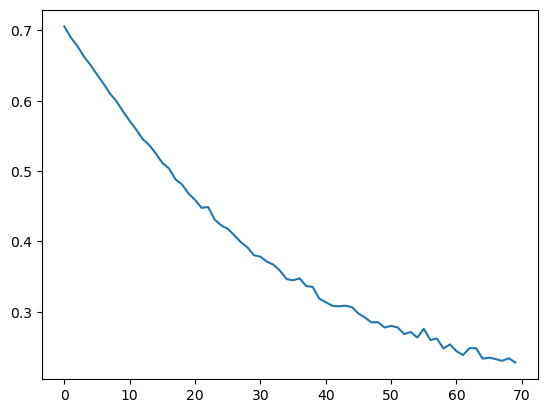

In [18]:
plt.plot(training_loss)

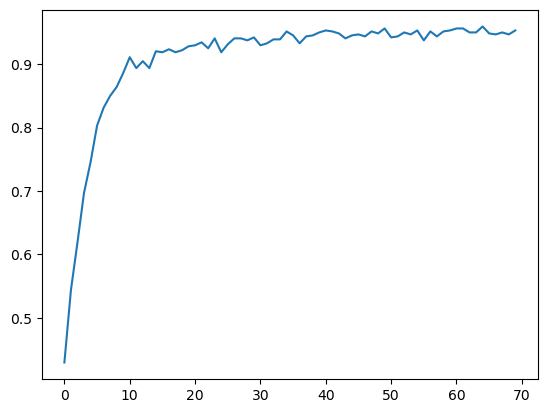

In [19]:
plt.plot(training_Acc)